In [26]:
import numpy as np
import operator
import logging
import time

import matplotlib.pyplot as plt

import optuna

import jax.numpy as jnp
from jax import grad, jit

from functools import partial
import gwjax
import gwjax.imrphenom

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter, sigmasq, get_cutoff_indices
from pycbc.psd.analytical import aLIGOAdVO3LowT1800545

In [27]:
class NeedsInvestigatingCallback(object):
    """A callback for Optuna which identifies potential events."""

    def __init__(self, early_stopping_rounds: int, snr_threshold: int, direction: str = "minimize") -> None:
        self.snr_threshold = snr_threshold
        self.early_stopping_rounds = early_stopping_rounds
        
        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Goes onto Stocastic Gradient Descent."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._score <= self.snr_threshold:
            if self._iter >= self.early_stopping_rounds:
                study.stop()
                print(study.best_params)
                
        if self._score >= self.snr_threshold:
            study.stop()
            print(f'Optuna has stopped with {study.best_params} because snr threshold has been reached.')
            # Perform gradient descent to find the lowest SNR
            initial_m1 = study.best_params['m1'] #from the Optuna section of GWtuna
            initial_m2 = study.best_params['m2'] #from the Optuna section of GWtuna
            initial_s1 = 0.0
            initial_s2 = 0.0
            # Set the learning rate and number of iterations for gradient descent
            mass_learning_rate = 0.1
            spin_learning_rate = 0.00001
            print(f'Jax is about to start using Gradient Descent')
            optimized_m1, optimized_m2, optimized_s1, optimized_s2 = gradient_descent(initial_m1, initial_m2, initial_s1, initial_s2, mass_learning_rate, spin_learning_rate, my_waveform_template, my_matched_filter, my_snr)
            print("Optimized Mass and Spin Parameters: m1 =", optimized_m1, "m2 =", optimized_m2, "s1 =", optimized_s1, "s2 =", optimized_s2)
            print("The SNR is with the optimized parameters:", -objective([optimized_m1, optimized_m2, optimized_s1, optimized_s2]))

In [28]:
# Define the conditiion data function
dynfac = 1.0e23
def condition(strain, sampling_rate):
    tmp = resample_to_delta_t(highpass(strain, 15.0), 1.0/sampling_rate).crop(2,2)
    return (dynfac*tmp)

# Define the PSD function 
def estimate_psd(strain, delta_f):
    psd = strain.psd(4)
    psd = interpolate(psd, delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15, trunc_method='hann')
    return psd

# Define the matched filter function
def matched_filter(signal_duration, sampling_rate, kmin, kmax, fcore, template): 
    workspace = jnp.zeros(int(sampling_rate*signal_duration), dtype=complex) 
    result_fft = fcore * jnp.conjugate(template) 
    workspace = workspace.at[kmin:kmax].set(result_fft)
    result = jnp.fft.ifft(workspace)
    result *= len(result)
    return result

# Define the waveform template function
def waveform_template(freqs, m1, m2, s1, s2):
    params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': m1, 'm2': m2, 'spin1': s1, 'spin2': s2,
            'ra': 0., 'dec': 0., 'pol': 0.}
    # Create the waveform template using the mass parameters
    # Adjust this function based on your specific waveform model
    #may want to do partial on this
    return gwjax.imrphenom.IMRPhenomD(freqs, params)

# Define the waveform template function
def injected_template(freqs, m1, m2, s1, s2):
    params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': m1, 'm2': m2, 'spin1': s1, 'spin2': s2,
            'ra': 0., 'dec': 0., 'pol': 0.}
    # Create the waveform template using the mass parameters
    # Adjust this function based on your specific waveform model
    #may want to do partial on this
    return gwjax.imrphenom.IMRPhenomD(freqs, params)

# Define sigma squared function 
def sigma_squared(delta_freq, invpsd, template):
    weighted_inner = jnp.sum(template*jnp.conj(template)*invpsd)
    h_norm = 4*delta_freq
    sigma_squared = jnp.real(weighted_inner)*h_norm
    #print(f'sigma_squared {sigma_squared}')
    return sigma_squared

# Define the waveform template function
def optuna_waveform_template(freqs, m1, m2):
    params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': m1, 'm2': m2, 'spin1': 0, 'spin2': 0,
            'ra': 0., 'dec': 0., 'pol': 0.}
    # Create the waveform template using the mass parameters
    # Adjust this function based on your specific waveform model
    #may want to do partial on this
    return gwjax.imrphenom.IMRPhenomD(freqs, params)

def snr(invpsd, delta_freq, sampling_rate, matched_output, sigma_squared_output):
    norm = 4*delta_freq / jnp.sqrt(sigma_squared_output)
    snr = matched_output*norm
    snr_min = int((2+4)*sampling_rate)
    snr_max = len(snr)-int((2)*sampling_rate)
    snr = snr[snr_min:snr_max]
    peak = jnp.argmax(jnp.absolute(snr))
    snrp = jnp.absolute(snr[peak])
    return(snrp)

# Define the objective function to minimize (negative SNR)
def objective(params):
    m1, m2, s1, s2 = params
    template, _ = my_waveform_template(m1, m2, s1, s2)
    #print(template)
    matched_output = my_matched_filter(template)
    #print(matched_output)
    sigma_squared_output = my_sigma_squared(template)
    #print(sigma_squared_output)
    snr_peak = my_snr(matched_output, sigma_squared_output)
    #print(snr_peak)
    return -snr_peak

# Perform gradient descent
def gradient_descent(initial_m1, initial_m2, initial_s1, initial_s2, mass_learning_rate, spin_learning_rate, my_waveform_template, my_matched_filter, my_snr):
    precision = 0.001
    iters = 0 
    Total_gradient = 0.1
    # Initialize the parameters
    m1, m2, s1, s2 = initial_m1, initial_m2, initial_s1, initial_s2
    
    # Define the gradient of the objective function
    objective_grad = jit(grad(objective))

    while abs(float(Total_gradient)) > precision:
        
        # Compute the gradient
        grad_m1, grad_m2, grad_s1, grad_s2 = objective_grad((m1, m2, s1, s2))
        
        # Update the parameters
        m1 -= mass_learning_rate * grad_m1
        m2 -= mass_learning_rate * grad_m2
        s1 -= spin_learning_rate * grad_s1
        s2 -= spin_learning_rate * grad_s2
        
        iters = iters+1 #iteration count
        
        Total_gradient = abs(float(grad_m1))
        
        if iters%100 == 0:
            print("Iteration",iters,"\n values is", m1, m2, s1, s2, "\n Total Gradient is", abs(float(grad_m1)))
        
        if s1<-0.99 or s1>0.99:
            print('Help the spin is out of range')
            break
            
    return m1, m2, s1, s2

In [29]:
#Defining the PSD
sampling_rate = 2048
signal_duration = int(28)
delta_freq = 1.0 / signal_duration

#Determine the low freq and high frequency cut off
kmin, kmax = 15*signal_duration, 900*signal_duration

psd = aLIGOAdVO3LowT1800545(1+signal_duration*sampling_rate//2, delta_f=delta_freq, low_freq_cutoff=12)
invpsd = psd**(-1)

(1.0, 10000.0)

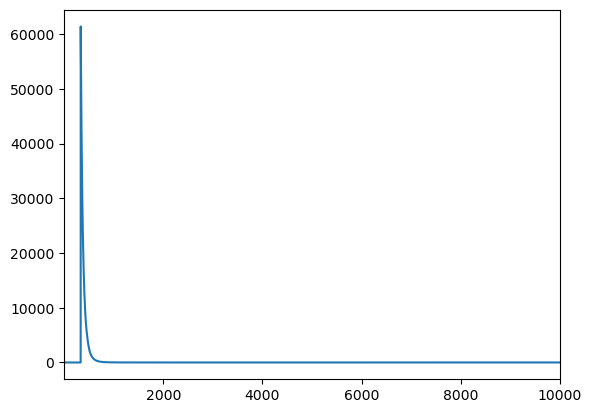

In [33]:
plt.plot(psd*dynfac**2)
plt.xlim(1, 10000)

In [6]:
#Get the frequency range
nyquist = sampling_rate//2
freqs = jnp.arange(1+(nyquist*signal_duration))/signal_duration

#Create an injection template
injection, _ = injected_template(freqs, m1=35, m2=24, s1=0.1, s2=0.1)

(1.0, 20.0)

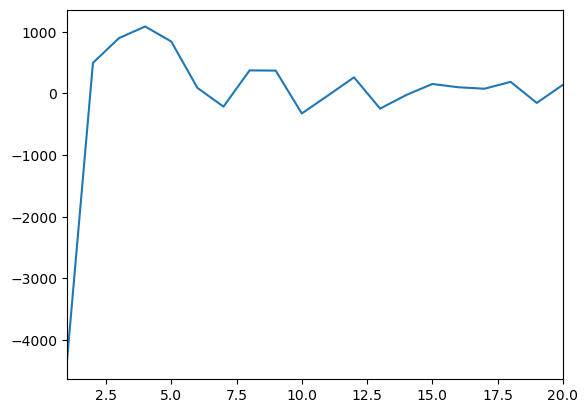

In [20]:
plt.plot(injection)
plt.xlim(1, 20)

In [8]:
#Add the noise to the template
injection = injection+jnp.asarray(psd)
print(injection)
#Define a variable that is the data/PSD
fcore = injection*jnp.asarray(invpsd)

#Make everything the same length
fcore = jnp.asarray(fcore[kmin:kmax])
print(len(fcore))
psd = jnp.asarray(psd[kmin:kmax])
print(len(psd))
invpsd = jnp.asarray(invpsd[kmin:kmax])
print(len(invpsd))
freqs = freqs[kmin:kmax]
print(len(freqs))

#Get the stage ready for the template
my_waveform_template = partial(waveform_template, freqs)
my_optuna_waveform_template = partial(optuna_waveform_template, freqs)
my_matched_filter = partial(matched_filter, signal_duration, sampling_rate, kmin, kmax, fcore)
my_sigma_squared = partial(sigma_squared, delta_freq, invpsd)
my_snr = partial(snr, invpsd, delta_freq, sampling_rate)

[            nan           +nanj -4.36363358e+03-3.48549297e+03j
  4.96519692e+02+2.43648895e+03j ...  8.46204998e-09-5.99625937e-09j
  8.46544471e-09-5.97997342e-09j  8.46881331e-09-5.96369303e-09j]
24780
24780
24780
24780


(1.0, 20.0)

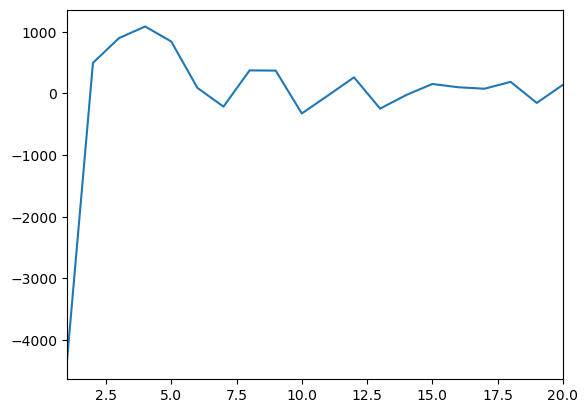

In [22]:
plt.plot(injection)
plt.xlim(1, 20)

In [10]:
def optuna_objective(trial):
    m1 = trial.suggest_float('m1', 2, 100, step=0.000001)
    m2 = trial.suggest_float('m2', 2, 100, step=0.000001)
    template, _ = my_optuna_waveform_template(m1, m2)
    matched_output = my_matched_filter(template)
    sigma_squared_output = my_sigma_squared(template)
    snr_peak = my_snr(matched_output, sigma_squared_output)
    return snr_peak

In [11]:
start_time = time.time()
#optuna.logging.disable_default_handler()
direction="maximize"
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction=direction)
needs_to_be_investigated = NeedsInvestigatingCallback(300, snr_threshold=19, direction=direction)
study.optimize(optuna_objective, callbacks=[needs_to_be_investigated], n_trials=500)
print("Time taken", time.time() - start_time)
print(f'The injection has the best {study.best_params} with a snr {study.best_value}')

[I 2023-05-31 10:01:49,768] A new study created in memory with name: no-name-807a267b-7baa-4fb2-be1f-080bc66c4b67
[I 2023-05-31 10:01:50,573] Trial 0 finished with value: 2.9763431539622706e+21 and parameters: {'m1': 59.494844, 'm2': 41.084249}. Best is trial 0 with value: 2.9763431539622706e+21.


Optuna has stopped with {'m1': 59.494844, 'm2': 41.084249} because snr threshold has been reached.
Jax is about to start using Gradient Descent
Help the spin is out of range
Optimized Mass and Spin Parameters: m1 = -1.7718914632154194e+16 m2 = 1.6684252984615424e+18 s1 = -3.3823145773358196e+16 s2 = -2.0366787294896376e+16
The SNR is with the optimized parameters: nan
Time taken 6.805654764175415
The injection has the best {'m1': 59.494844, 'm2': 41.084249} with a snr 2.9763431539622706e+21
